# Import libraries

In [1]:
from pyensembl import EnsemblRelease
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import methylcheck
import pickle
from sklearn.decomposition import PCA
import umap.umap_ as umap

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Change Ensembl IDs to HGNC

## Open preocessed data

In [ ]:
with open('../Processed_Data/BCCA_Counts.pickle', 'rb') as f:
    df = pickle.load(f)

In [ ]:
with open('../Processed_Data/meta_data.pickle', 'rb') as f:
    gene_meta_data = pickle.load(f)

## Gather meta data of all identified genes

In [ ]:
# genome = GRCh38
# 9033 Ensembl IDs were not identified
# 11309 Ensembl IDs were identified but have no Gene ID (as for the reference genome GRCh38)
    # These 11309 were included in meta_data.pickle (gene_meta_data dataframe)

Genome = EnsemblRelease()
gene = Genome.gene_by_id(df.index[0])
gene_meta_data = pd.Series([gene.gene_id, gene.gene_name, gene.biotype, gene.contig, gene.start, gene.end, gene.strand]).to_frame().transpose()

unnamed_genes = []


for id, ensembl in enumerate(df.index):
    try:

        if id == 0:
            continue
        
        gene = Genome.gene_by_id(ensembl)

        temp_list = pd.Series([gene.gene_id, gene.gene_name, gene.biotype, gene.contig, gene.start, gene.end, gene.strand]).to_frame().transpose()
        gene_meta_data = gene_meta_data.append(temp_list)

    except:
        
        unnamed_genes.append(ensembl)

gene_meta_data = gene_meta_data.rename(columns={0:'Gene_ID', 1:'Gene_Name', 2:'Gene_Biotype', 3:'Contig_Chromosome', 4:'Start', 5:'End', 6:'Strand'})
gene_meta_data = gene_meta_data.set_index("Gene_ID")

## Drop nameless genes

In [ ]:
identified_nameless_genes = []

for id, ensembl in enumerate(df.index):
    try:
        gene = Genome.gene_by_id(ensembl)

        if gene.gene_name == "":
            identified_nameless_genes.append(ensembl)
            continue
    except:
        continue

gene_meta_data2 = gene_meta_data.drop(identified_nameless_genes)
gene_names_column = gene_meta_data2["Gene_Name"]

df2 = df.drop(unnamed_genes)
df2 = df2.join(gene_names_column.to_frame()).set_index("Gene_Name")

## Processing clinical data

In [ ]:
clinical_data = pd.read_csv("../Raw_Data/clinical_data.csv")
clinical_data = clinical_data.rename(columns={"TARGET USI":"Patient_ID"}).set_index("Patient_ID")

## Export data

### BCCA_Counts with identified genes as HGNC

In [ ]:
with open('../Data/Pre_Processed/HGNC_BCCA_Counts.pickle', 'wb') as f:
    pickle.dump(df2, f)

### Clinical Data

In [ ]:
with open('../Data/Pre_Processed/clinical_data.pickle', 'wb') as f:
    pickle.dump(clinical_data, f)

### Gene Meta Data

In [ ]:
with open('../Data/Pre_Processed/meta_data.pickle', 'wb') as f:
    pickle.dump(gene_meta_data, f)

### List of not-found genes

In [ ]:
with open('../Data/Pre_Processed/unnamed_genes.pickle', 'wb') as f:
    pickle.dump(unnamed_genes, f)

# Log Scaling the data

In [3]:
HGNC_BCCA_Counts = pd.read_pickle("../Data/Pre_Processed/HGNC_BCCA_Counts.pickle")
HGNC_Log_Scaled = np.log2(HGNC_BCCA_Counts + 1)
description_log_scaled_dataset = HGNC_Log_Scaled.T.describe().T
HGNC_Log_Scaled = HGNC_Log_Scaled[description_log_scaled_dataset["std"] > 0] # Adjusting for non-expressed genes (37688 in total)

## Density plot

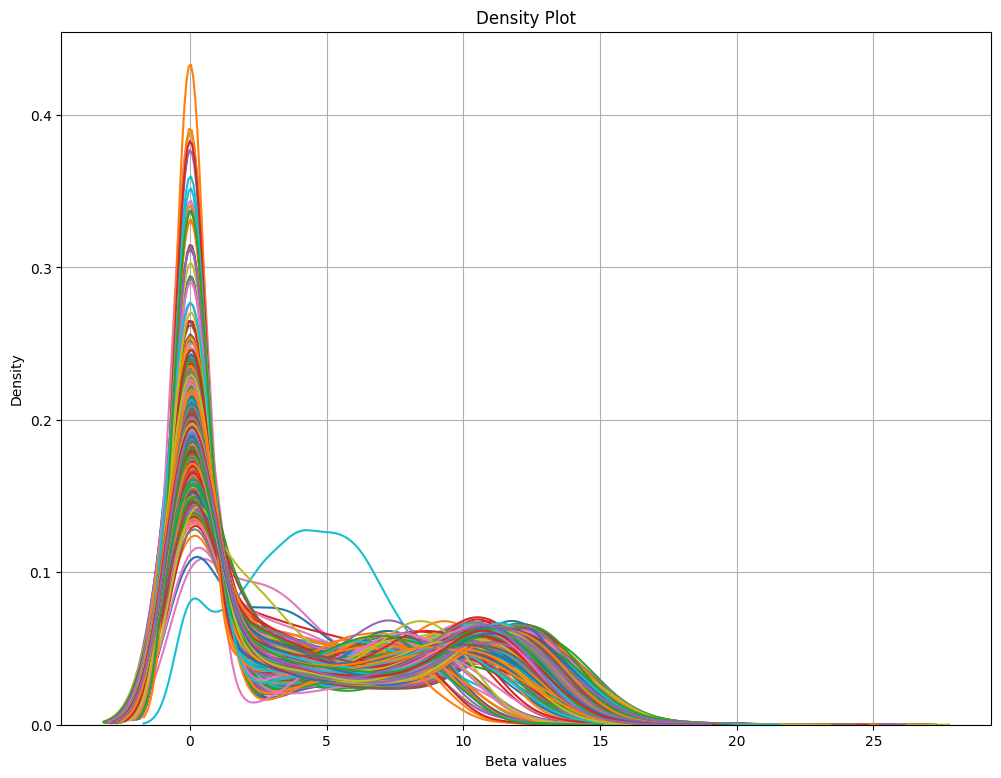

In [4]:
methylcheck.beta_density_plot(HGNC_Log_Scaled, full_range=True, plot_title="Density Plot") # Per-gene expression range

# Creating a main data frame

In [5]:
df0 = HGNC_Log_Scaled.T.reset_index()

In [6]:
df1 = df0.join(df0['index'].str.rsplit(pat='-',n=2,expand=True)[0])
df2 = df1.set_index(0)

In [8]:
clinical_data = pd.read_pickle("../Data/Pre_Processed/clinical_data.pickle")
clinical_data2 = clinical_data.reset_index().drop_duplicates(subset='Patient_ID').set_index('Patient_ID')

In [9]:
df3 = df2.join(clinical_data2, how='inner')

In [15]:
df4 = df3.set_index("index")

In [16]:
df5 = df4[df4["Protocol"] == "AAML1031"]

In [19]:
df5_clinical  = df5.iloc[:,df3.shape[1]-clinical_data2.shape[1]-1:]

In [68]:
x = df5.iloc[:,:df3.shape[1]-clinical_data2.shape[1]-2]

## Export

In [67]:
# Clinical Data
df5_clinical.to_pickle("../Data/clinical_data.pickle")

# Processed Data
x.to_pickle("../Data/processed_data.pickle")

# Repartitioning to upload to GitHub


In [70]:
quarter = x.shape[0]//4
x_1 = x[:quarter]
x_1.to_pickle("../Data/Processed_Data/part_1.pickle")
x_2 = x[quarter:2*quarter]
x_2.to_pickle("../Data/Processed_Data/part_2.pickle")
x_3 = x[2*quarter:3*quarter]
x_3.to_pickle("../Data/Processed_Data/part_3.pickle")
x_4 = x[3*quarter:]
x_4.to_pickle("../Data/Processed_Data/part_4.pickle")

In [72]:
final = pd.read_pickle("../Data/Processed_Data/part_1.pickle")
test2 = pd.read_pickle("../Data/Processed_Data/part_2.pickle")
test3 = pd.read_pickle("../Data/Processed_Data/part_3.pickle")
test4 = pd.read_pickle("../Data/Processed_Data/part_4.pickle")

In [73]:
final = final.append(test2)
final = final.append(test3)
final = final.append(test4)

# PCA

In [327]:
# Fit PCA
pca_decomp = PCA(random_state=42, n_components=2)
data_PCs = pca_decomp.fit_transform(x)

In [353]:
def draw_PCAplot(score, hue=None):
    
    sns.set_theme(style="white", color_codes=True)

    # Define variables
    score2 = score[:,0:2]
    xs = score2[:,0]
    ys = score2[:,1]

    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    # Define scatterplot

    sns.scatterplot(x=xs * scalex, y=ys * scaley,
                    palette='husl', s=10,
                    linewidth=0, alpha=1,
                    data=df5_clinical, hue=hue)

    # Define plot specs
    plt.title("PCA Decomposition by RNA-seq",
               fontsize = 12)        
               
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.tight_layout()

    # Save figure
    #plt.savefig('test' + title + '.png',
    #bbox_inches='tight', dpi=300)

    return(plt.show())

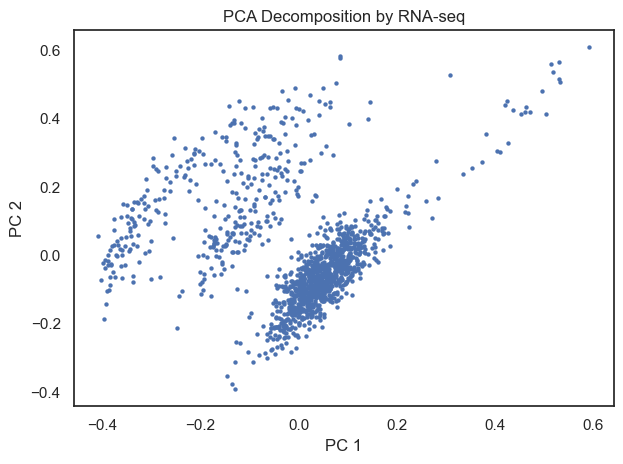

In [354]:
draw_PCAplot(data_PCs)
draw_PCAplot(data_PCs, hue='Protocol')

In [344]:
df5_clinical["Protocol"].value_counts()

AAML1031    1038
AAML0531     246
AAML03P1      67
CCG2961       53
Name: Protocol, dtype: int64

# UMAP

In [345]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.01, n_epochs=100, random_state=42)
mp_umap = reducer.fit_transform(x)

In [355]:
def draw_UMAPplot(score, hue=None):
    
    sns.set_theme(style="white", color_codes=True)

    # Define variables
    score2 = score[:,0:2]
    xs = score2[:,0]
    ys = score2[:,1]

    # Define scatterplot

    sns.scatterplot(data=df5_clinical, x=xs, y=ys,
                    palette='husl', s=10,
                    linewidth=0, alpha=1, hue=hue)

    # Define plot specs
    plt.title("UMAP by RNA-seq",
               fontsize = 12)        
               
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.tight_layout()

    # Save figure
    #plt.savefig('test2' + title + '.png',
    #bbox_inches='tight', dpi=300)

    return(plt.show())

In [357]:
df5_clinical["Protocol"].value_counts()

AAML1031    1038
AAML0531     246
AAML03P1      67
CCG2961       53
Name: Protocol, dtype: int64

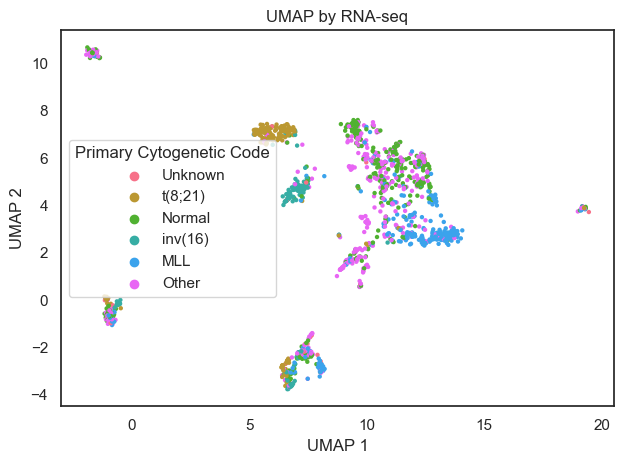

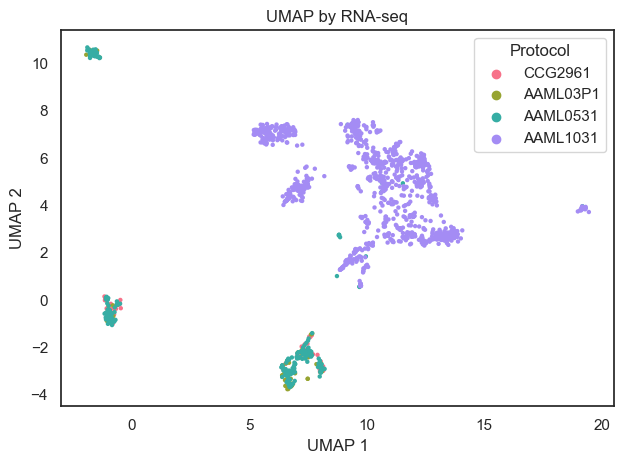

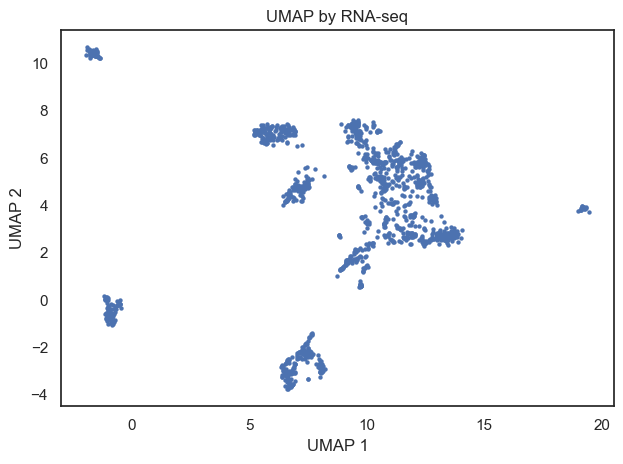

In [356]:
#Call the UMAP function.
draw_UMAPplot(mp_umap, hue="Primary Cytogenetic Code")
draw_UMAPplot(mp_umap, hue="Protocol")
draw_UMAPplot(mp_umap)

# Testing
Ignore

In [224]:
clinical_data = pd.read_pickle("../Data/Pre_Processed/clinical_data.pickle")

In [206]:
clinical_data["Primary Cytogenetic Code"].value_counts() # Types of AML

Other      696
Normal     598
MLL        501
t(8;21)    343
inv(16)    280
Unknown     68
Name: Primary Cytogenetic Code, dtype: int64

aqui jaz - 

```python
patients = HGNC_Log_Scaled.columns.values.tolist()
patients = [w[:-8] for w in patients]
res = []
duplicates = []
for x in patients:
    if x not in res:
        res.append(x)
    else:
        duplicates.append(x)

# initial length of res = 1475
# final length of res = 1411
# ----------
# 64 duplicates (length of duplicates)

duplicates_2 = []
res_2 = []
for x in temp.index.tolist():
    if x not in res_2:
        res_2.append(x)
    else:
        duplicates_2.append(x)
```